<a href="https://colab.research.google.com/github/mrpintime/Dota2_TI-2016/blob/main/Dota2Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dota2 TI 2016 Team Performance
Created by Mrpintime


# Dataset Description

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

The data was collected using: https://gist.github.com/da-steve101/1a7ae319448db431715bd75391a66e1b


Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5 - end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

The hero to id mapping can be found here: https://github.com/kronusme/dota2-api/blob/master/data/heroes.json
Dataset Url: https://archive.ics.uci.edu/dataset/367/dota2+games+results

# Problem
We want to know can we predict winner of the games with these features ?:)  
and find out which hero has more impact on games ?

# Data Wrangling

Import necessary Libraries

In [1]:
def warns (*args, **kwargs):
  pass

import warnings

# ignore warnings
warnings.warn = warns

In [ ]:
# first lets install cuML for fast tsne implementation
!pip install umap-learn
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [13]:
import pandas as pd, seaborn as sns, numpy as np, matplotlib.pyplot as plt
import cuml
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import umap
from sklearn.cluster import DBSCAN, MeanShift, estimate_bandwidth
import gc
# from sklearn.preprocessing import StandardScaler


**Note**: you can use high level libraries like Dataprep to do data cleaning and exploratory data analysis but i suggest you if you want to learn and be dominant on your data science knowledge use fundamental libraries like pandas, numpy and ...

Download dataset form UCI site

In [ ]:
# ! curl https://archive.ics.uci.edu/static/public/367/dota2+games+results.zip --output dota2.zip

Save files on google drive to reuse them.

In [ ]:
# !cp "/content/dota2.zip" "/content/drive/MyDrive/Dota2/"

In [ ]:
# !unzip "/content/drive/MyDrive/Dota2/dota2.zip" -d "/content/drive/MyDrive/Dota2/"

So we saved our datasets to our drive google drive, as you can see we have to seperate dataset as test and train, we have to check them for data preprocessing.

## Data Cleaning

We need to import datasets and clean them.

In [7]:
# df_trn = pd.read_csv('/content/drive/MyDrive/Dota2/dota2Train.csv', header=None)
# df_tst = pd.read_csv('/content/drive/MyDrive/Dota2/dota2Test.csv', header=None)

In [ ]:
df_trn.shape, df_tst.shape

((92650, 117), (10294, 117))

In [ ]:
df_trn.isnull().sum().sum(), df_tst.isnull().sum().sum()

(0, 0)

Hoorayyyy, we do not have any null value in train and test set.

Lets first prepare train set

In [ ]:
df_tst.head()

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_trn.head()

,0,1,2,3,4,5,6,7,8,9,...,107,108,109,110,111,112,113,114,115,116
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
2,1,131,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,1,154,2,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,171,2,3,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0


> Column '-1' is for status of game or which team is winner at the end of the game.
---
> Column '223' is related to server location that two team play in it. [Link](https://github.com/kronusme/dota2-api/blob/master/data/regions.json)
---
> Column '2' is for game mode.   [Link](https://github.com/kronusme/dota2-api/blob/master/data/mods.json)
---
> Column '2.1' is for game type. [Link](https://github.com/kronusme/dota2-api/blob/master/data/lobbies.json)
---
> All other columns indicate a heros in the game. [Link](https://github.com/kronusme/dota2-api/blob/master/data/heroes.json)

In [ ]:
df_trn.iloc[0, 4:].value_counts()

 0    103
 1      5
-1      5
Name: 0, dtype: int64

We can see as was in description each row contains 5 heros to one team and 5 to another team that indicate with 1 and -1 and all other heros value set to 0.  
in Overall we have 113 heros in game.  
You can see all heros here : [Link](https://github.com/kronusme/dota2-api/blob/master/data/heroes.json)   

In [ ]:
# ['Won', 'Server', 'Game_mode', 'Game_type']+ hero_list

In [ ]:
hero_list = [f'Hero_{i+1}' for i in range(113)]
new_columns_name = ['Won', 'Server', 'Game_mode', 'Game_type'] + hero_list

Both test and train have equal columns

In [ ]:
df_tst.columns = new_columns_name
df_trn.columns = new_columns_name

In [ ]:
df_trn.head(2)

,Won,Server,Game_mode,Game_type,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Hero_6,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,-1,223,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,152,2,2,0,0,0,1,0,-1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tst.head(2)

,Won,Server,Game_mode,Game_type,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Hero_6,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0


# EDA

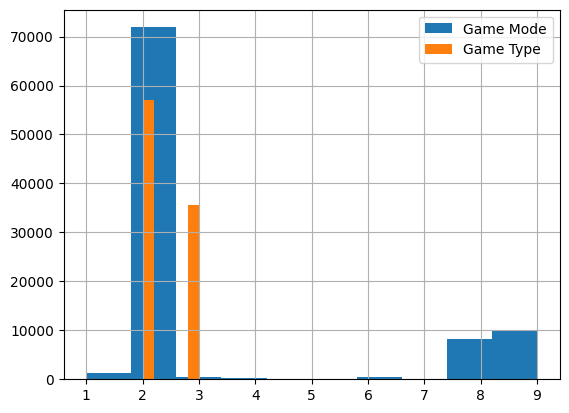

In [ ]:
df_trn.Game_mode.hist(label='Game Mode')
df_trn.Game_type.hist(label='Game Type')
plt.legend()

The most ferquent Game type are `2:Tournament` and `3:Tutorial`.  
The most ferquent Game mode are `2:Captains Mode`, `8:Reverse Captains Mode` and `9:Greeviling Mode`

In [ ]:
aug = df_trn.iloc[:, 4: ].abs().sum(axis=0)
aug

Hero_1      14973
Hero_2      20264
Hero_3       2524
Hero_4      11702
Hero_5      10050
            ...  
Hero_109     4513
Hero_110     3862
Hero_111     2637
Hero_112     3340
Hero_113     1791
Length: 113, dtype: int64

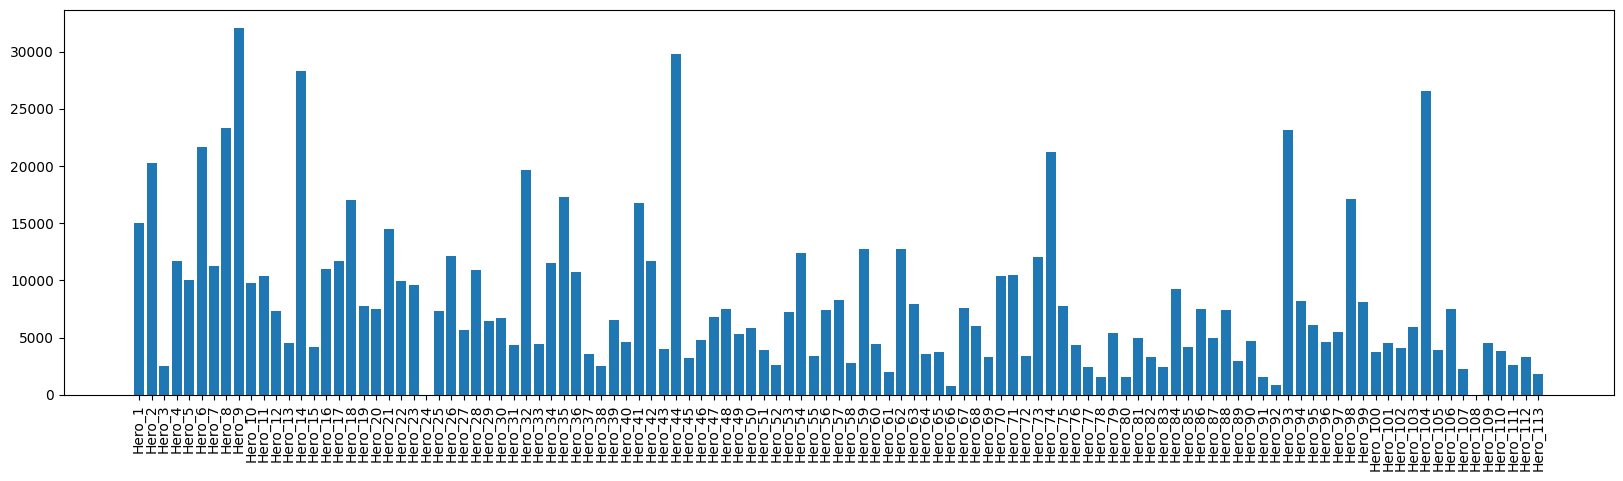

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(x=aug.index, height=aug)

plt.xticks(rotation=90)
plt.show()

In [ ]:
mask = (aug.sort_values(ascending=False)/aug.sum() * 100) > 1

aug[mask].sort_values(ascending=False)

Hero_9      32048
Hero_44     29802
Hero_14     28285
Hero_104    26521
Hero_8      23327
Hero_93     23125
Hero_6      21700
Hero_74     21262
Hero_2      20264
Hero_32     19670
Hero_35     17276
Hero_98     17155
Hero_18     17029
Hero_41     16746
Hero_1      14973
Hero_21     14473
Hero_62     12717
Hero_59     12707
Hero_54     12361
Hero_26     12108
Hero_73     12069
Hero_4      11702
Hero_17     11688
Hero_42     11650
Hero_34     11558
Hero_7      11276
Hero_16     11013
Hero_28     10878
Hero_36     10729
Hero_71     10449
Hero_11     10410
Hero_70     10368
Hero_5      10050
Hero_22      9968
Hero_10      9807
Hero_23      9635
dtype: int64

In [ ]:
aug[aug==0]

Hero_24     0
Hero_108    0
dtype: int64

In [ ]:
def calc_win_rate(hero):
  all = df_trn[df_trn[f'Hero_{hero}'] != 0].loc[:, ['Won', f'Hero_{hero}']]
  all_game = all.shape[0]
  wins = 0
  for i,(w,s) in all.iterrows():
    if w == s:
      wins += 1
  # print('Win_Rate = ', (wins/all_game)*100)
  try:
    win_r = np.round((wins/all_game)*100, 2)
  except ZeroDivisionError:
    win_r = 0
  return win_r

print(calc_win_rate('113'))

43.33


In [ ]:
win_rate = dict()
cls = df_trn.iloc[:, 4:].columns
for c in cls:
  q = c.split('_')[1]
  win_rate[f'Hero_{q}'] = calc_win_rate(f'{q}')

In [ ]:
win_rate_df = pd.DataFrame(win_rate, index = [0])

In [ ]:
win_rate_df

,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,Hero_6,Hero_7,Hero_8,Hero_9,Hero_10,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,46.7,52.7,45.01,50.75,54.77,53.47,50.16,50.44,55.32,50.15,...,48.71,47.48,42.17,42.61,0,48.81,51.27,43.42,44.64,43.33


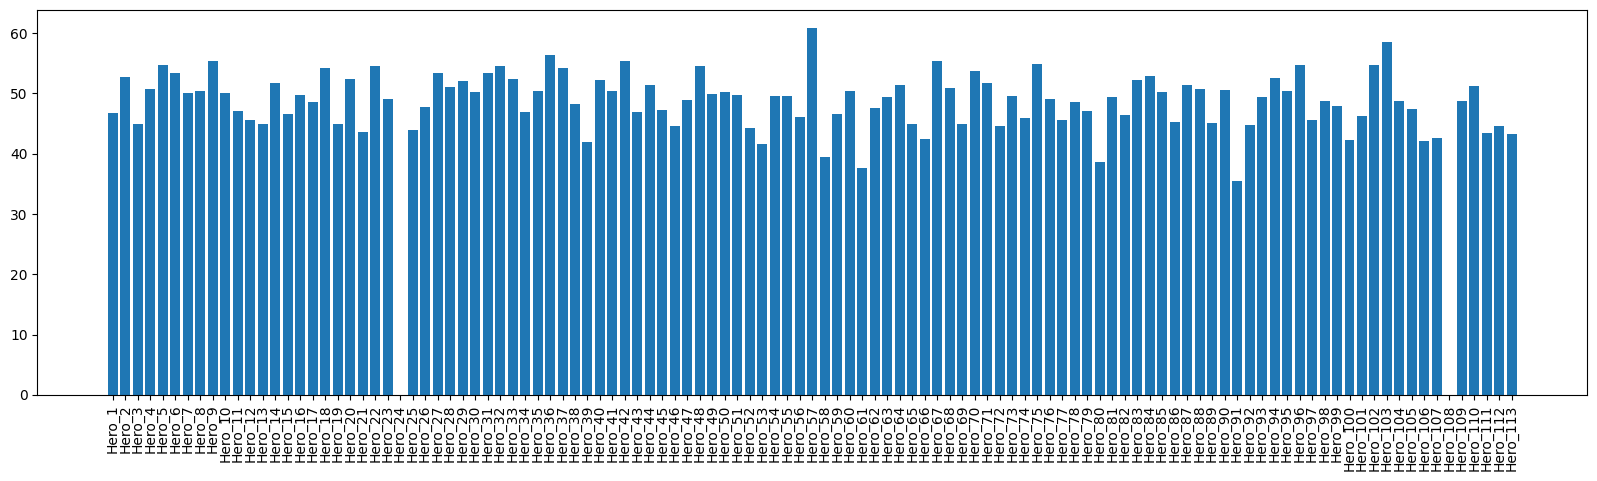

In [ ]:
plt.figure(figsize=(20,5))
plt.bar(x=win_rate_df.columns, height=win_rate_df.values[0])

plt.xticks(rotation=90)
plt.show()

In [ ]:
df_trn[df_trn['Hero_57'] != 0].shape, df_trn[df_trn['Hero_113'] != 0].shape

((8320, 115), (1791, 115))

**`Hero 24` and `Hero 108` never picked in train set.**

So as you can see here `Hero_91` has **lowest win rate** unless name of the hero is `Wisp` and with a few search we can find out that **pro player** pick this hero **more** than number we saw here and also this hero has **higher win rate**.

---

> So here in this dataset we have all games in 2016 and this is not just pro players games (TI event), this is also include other players game such as public games in 2016.

> One thing else is if we assume this data set is just for TI event we have to have much less game rather than we see here in this data set.

Lets check variation of heros in tets set

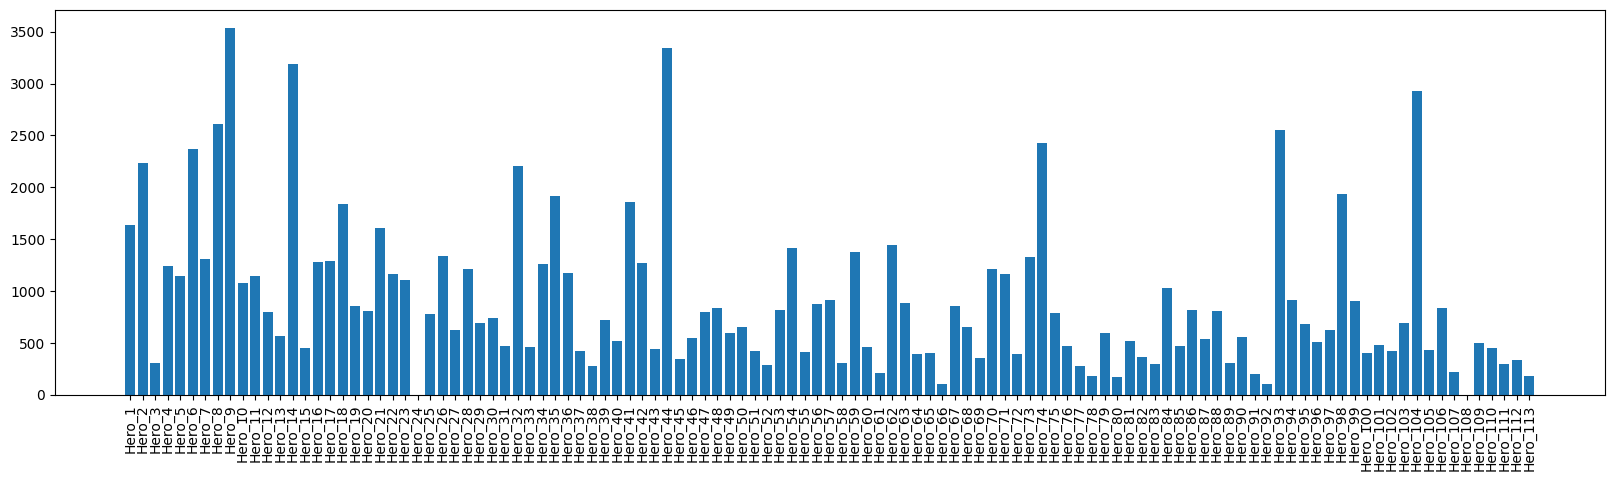

In [ ]:
aug_test = df_tst.iloc[:, 4: ].abs().sum(axis=0)
plt.figure(figsize=(20,5))
plt.bar(x=aug_test.index, height=aug_test)

plt.xticks(rotation=90)
plt.show()

Just like train set we do not have any picking in `hero 24` and `hero 108`.  
for `hero 24` if we check linke corresponded to heros we see that we don't have any hero related to id 24. So we can remove column 24 but not 108 because if we gathered another data from dota we may have hero 108 in teams so our model have to be stable for that moment.

In [ ]:
# remove column hero_24 from test and train set

df_tst = df_tst.drop(columns='Hero_24')
df_trn = df_trn.drop(columns='Hero_24')

Check server column in train set

In [ ]:
mask = df_trn.Server.value_counts(normalize=True) * 100 > 2
df_trn.Server.value_counts()[mask]

227    7874
154    7013
156    6899
151    6848
153    6757
152    6715
155    6611
224    5963
231    3666
223    3501
225    2643
Name: Server, dtype: int64

As we saw above results we see that 154 and 156 are one of the top servers but if we look at api of server we see both of them are for one specific region.
So we need some prepration on `Server` column.

In [ ]:
regions= [
        {
            "id" : 111,
            "name" : "US West"
        },
        {
            "id" : 112,
            "name" : "US West"
        },
        {
            "id" : 113,
            "name" : "US West"
        },
        {
            "id" : 114,
            "name" : "US West"
        },
        {
            "id" : 121,
            "name" : "US East"
        },
        {
            "id" : 122,
            "name" : "US East"
        },
        {
            "id" : 123,
            "name" : "US East"
        },
        {
            "id" : 124,
            "name" : "US East"
        },
        {
            "id" : 131,
            "name" : "Europe West"
        },
        {
            "id" : 132,
            "name" : "Europe West"
        },
        {
            "id" : 133,
            "name" : "Europe West"
        },
        {
            "id" : 134,
            "name" : "Europe West"
        },
        {
            "id" : 135,
            "name" : "Europe West"
        },
        {
            "id" : 136,
            "name" : "Europe West"
        },
        {
            "id" : 137,
            "name" : "Europe West"
        },
        {
            "id" : 138,
            "name" : "Europe West"
        },
        {
            "id" : 142 ,
            "name" : "South Korea"
        },
        {
            "id" : 143,
            "name" : "South Korea"
        },
        {
            "id" : 144,
            "name" : "South Korea"
        },
        {
            "id" : 145,
            "name" : "South Korea"
        },
        {
            "id" : 151 ,
            "name" : "Southeast Asia"
        },
        {
            "id" : 152,
            "name" : "Southeast Asia"
        },
        {
            "id" : 153,
            "name" : "Southeast Asia"
        },
        {
            "id" : 154,
            "name" : "Southeast Asia"
        },
        {
            "id" : 155,
            "name" : "Southeast Asia"
        },
        {
            "id" : 156,
            "name" : "Southeast Asia"
        },
        {
            "id" : 161,
            "name" : "China"
        },
        {
            "id" : 163,
            "name" : "China"
        },
        {
            "id" : 171,
            "name": "Australia"
        },
        {
            "id" : 181,
            "name" : "Russia"
        },
        {
            "id" : 182,
            "name" : "Russia"
        },
        {
            "id" : 183,
            "name" : "Russia"
        },
        {
            "id" : 184,
            "name" : "Russia"
        },
        {
            "id" : 185,
            "name" : "Russia"
        },
        {
            "id" : 186,
            "name" : "Russia"
        },
        {
            "id" : 187,
            "name" : "Russia"
        },
        {
            "id" : 188,
            "name" : "Russia"
        },
        {
            "id" : 191,
            "name" : "Europe East"
        },
        {
            "id" : 192,
            "name" : "Europe East"
        },
        {
            "id" : 200,
            "name" : "South America"
        },
        {
            "id" : 202,
            "name" : "South America"
        },
        {
            "id" : 203,
            "name" : "South America"
        },
        {
            "id" : 204,
            "name" : "South America"
        },
        {
            "id" : 211,
            "name" : "South Africa"
        },
        {
            "id" : 212,
            "name" : "South Africa"
        },
        {
            "id" : 213,
            "name" : "South Africa"
        },
        {
            "id" : 221,
            "name" : "China"
        },
        {
            "id" : 222,
            "name" : "China"
        },
        {
            "id" : 223,
            "name" : "China"
        },
        {
            "id" : 224,
            "name" : "China"
        },
        {
            "id" : 225,
            "name" : "China"
        },
        {
            "id" : 227,
            "name" : "China"
        },
        {
            "id" : 231,
            "name" : "China"
        },
        {
            "id" : 241,
            "name" : "Chile"
        },
        {
            "id" : 242,
            "name" : "Chile"
        },
        {
            "id" : 251,
            "name" : "Peru"
        },
        {
            "id" : 261,
            "name" : "India"
        }
    ]

In [ ]:
server_name = []
server_encode = []
for i in regions:
  server_name.append(i['name'])
  server_encode.append(i['id'])

In [ ]:
# add unknown server
unknown_s = []
for i in np.unique(df_trn.Server):
  if i in server_encode:
    pass
  else:
    unknown_s.append(i)

print(unknown_s)

[232]


We can see Server 232 is not in our region list, so we name it Unknown server.

Add Region column to train and test set

In [ ]:
for k, l in zip((df_trn.Server, df_tst.Server), ('train', 'test')):
  reg_server = []
  for i in k:
    for x, y in zip(server_name, server_encode):
      if i == y:
        reg_server.append(x)
        break
      elif i in unknown_s:
        reg_server.append('Unknown')
        break
  if l == 'train':
    df_trn['Region'] = reg_server
  elif l == 'test':
    df_tst['Region'] = reg_server

In [ ]:
# re-arrange columns
new_heros = df_trn.columns[4:-1].to_list()
cls = ['Won', 'Region', 'Server', 'Game_mode', 'Game_type'] + new_heros

# save a original copy
orig_trn = df_trn.copy()
orig_tst = df_tst.copy()

df_trn = df_trn[cls]
df_tst = df_tst[cls]

Plot the Region in bar visualization

<Axes: >

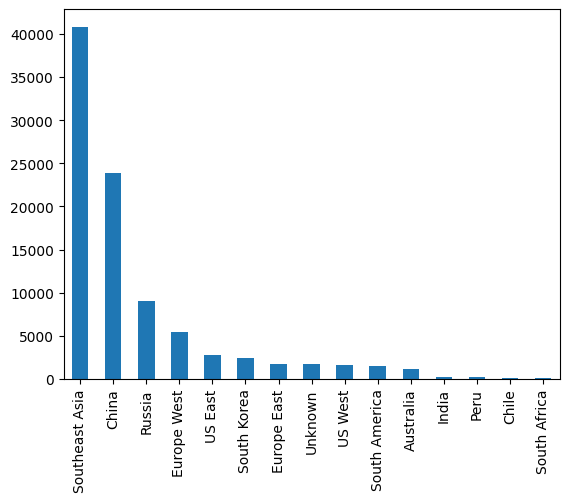

In [ ]:
df_trn.Region.value_counts().plot.bar()

As we can see the most server usage is `Southeast Asia`
and we a few search we find out that in 2016 and 2017 we had 16 server that i listed below:
> Southeast Asia, China, Russia, Europe West, US East, South Korea, Europe East, `Japan`, `Dubai`, US West, South America, Australia, India, Peru, Chile, South Africa.  

One thing else i think worth nothing to say is we have `Unknown` server in our dataset and we think some of `Unknown` servers are `Japan` and some others are `Dubai`.  

We can see we have balance variation in target variable in train and test set.

In [ ]:
df_trn.Won.value_counts(normalize=True)

 1    0.526519
-1    0.473481
Name: Won, dtype: float64

In [ ]:
df_tst.Won.value_counts(normalize=True)

 1    0.534486
-1    0.465514
Name: Won, dtype: float64

Lets save preproccessed train and test dataset

In [ ]:
# df_trn.to_csv('/content/drive/MyDrive/Dota2/preprocessed2_train.csv', index=False)
# df_tst.to_csv('/content/drive/MyDrive/Dota2/preprocessed2_test.csv', index=False)

cell for Read preprocessed data later

In [4]:
df_trn = pd.read_csv('/content/drive/MyDrive/Dota2/preprocessed2_train.csv')
df_tst = pd.read_csv('/content/drive/MyDrive/Dota2/preprocessed2_test.csv')

In [5]:
df_tst.shape, df_trn.shape

((10294, 117), (92650, 117))

In [6]:
df_trn.head()

,Won,Region,Server,Game_mode,Game_type,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,-1,China,223,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Southeast Asia,152,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,Europe West,131,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,Southeast Asia,154,2,2,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,Australia,171,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Clustering & Dimensionality Reduction  

**Lets do tsne and pca**

### PCA

We do not do scaling for this dataset beacuse it makes our analysis difficult and also in dataset like this we do not need scaling.  

---

our values are 1 or -1 at almost all variables in our dataset

In [10]:
encoder = LabelEncoder()
encoder.fit(np.concatenate([df_trn.Region, df_tst.Region], axis=0))

reg_enc_tr = encoder.transform(df_trn.Region)
reg_enc_ts = encoder.transform(df_tst.Region)

In [6]:
#replace categorical region
df_trn.Region =  reg_enc_tr
df_tst.Region =  reg_enc_ts

In [11]:
# Free RAM
del reg_enc_tr, reg_enc_ts
gc.collect()

92

In [6]:
df_trn.head()

,Won,Region,Server,Game_mode,Game_type,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,-1,2,223,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11,152,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,131,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,11,154,2,2,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,0,171,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


lets implement pca

In [18]:
pca_tr = PCA(n_components=3)
pca_ts = PCA(n_components=3)

trans_pca_trn = pca_tr.fit_transform(df_trn.iloc[:, 1:])
trans_pca_tst = pca_ts.fit_transform(df_tst.iloc[:, 1:])

In [19]:
np.cumsum(pca_tr.explained_variance_ratio_) * 100

array([98.0795842 , 98.71357468, 99.21656659])

In [20]:
np.cumsum(pca_ts.explained_variance_ratio_)* 100

array([98.08108388, 98.70766071, 99.21798051])

As we can see with 3 components we can explain 99 percent of variance of our data

In [21]:
pca_df_tr = pd.DataFrame(trans_pca_trn, columns=['pca_1','pca_2', 'pca_3'])
pca_df_ts = pd.DataFrame(trans_pca_tst, columns=['pca_1','pca_2', 'pca_3'])

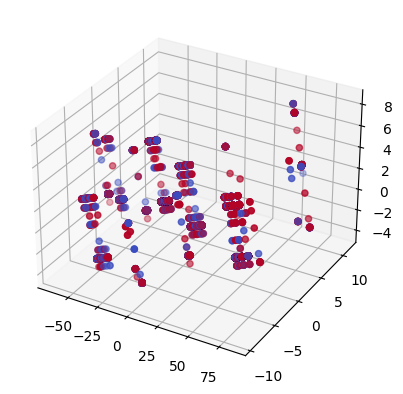

In [22]:
ax1 = plt.axes(projection='3d')

ax1.scatter(pca_df_ts.pca_1, pca_df_ts.pca_2, pca_df_ts.pca_3, c=df_tst.Won, cmap='coolwarm')
plt.show()

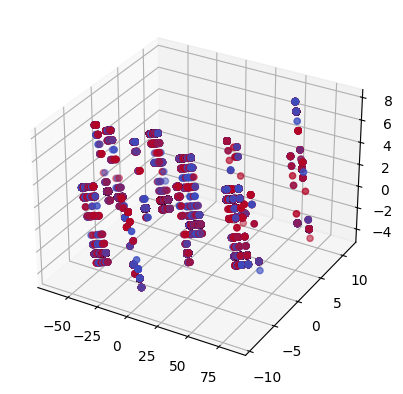

In [23]:
ax = plt.axes(projection='3d')

ax.scatter(pca_df_tr.pca_1, pca_df_tr.pca_2, pca_df_tr.pca_3, c=df_trn.Won, cmap='coolwarm')
plt.show()

<Axes: xlabel='pca_1'>

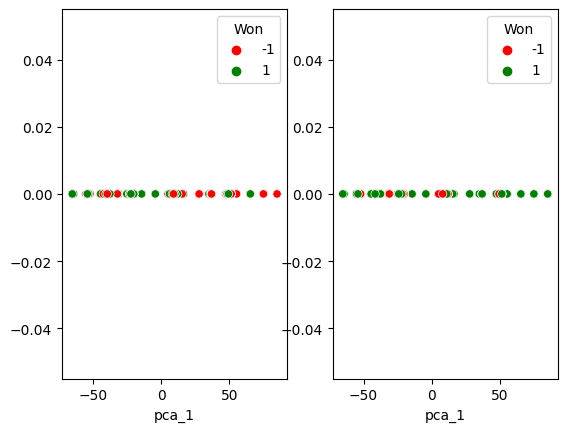

In [24]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=pca_df_tr.pca_1, y=np.zeros(pca_df_tr.pca_2.shape[0]), hue=df_trn.Won, palette=['r', 'g'], ax=ax[0])
sns.scatterplot(x=pca_df_ts.pca_1, y=np.zeros(pca_df_ts.pca_2.shape[0]), hue=df_tst.Won, palette=['r', 'g'], ax=ax[1])

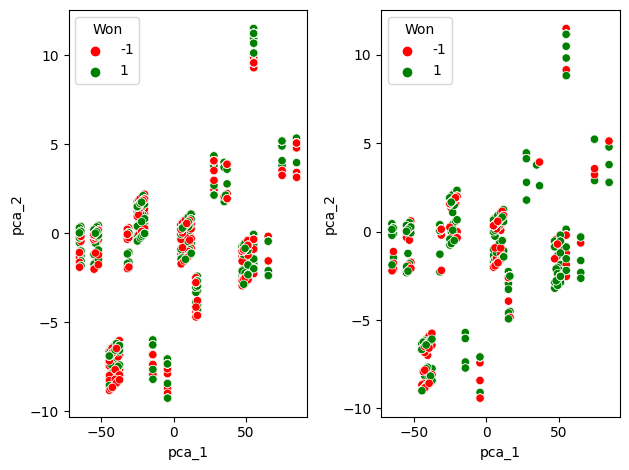

In [41]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(x=pca_df_tr.pca_1, y=pca_df_tr.pca_2, hue=df_trn.Won, palette=['r', 'g'], ax=ax[0])
sns.scatterplot(x=pca_df_ts.pca_1, y=pca_df_ts.pca_2, hue=df_tst.Won, palette=['r', 'g'], ax=ax[1])

plt.tight_layout()
plt.show()

As we can see with linear pca we can not draw exact decision boundery    
But we can see the data create different clusters.

### TSNE
---

Lets implement tsne

In [26]:
tsne = cuml.manifold.TSNE(n_components=2, perplexity=30, init='pca')

tsne_df_tr = tsne.fit_transform(df_trn.iloc[:, 1:])
tsne_df_ts = tsne.fit_transform(df_tst.iloc[:, 1:])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: TSNE does not support pca but only random initialization.
  return func(**kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [15:41:27.006239] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [15:41:31.479808] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [27]:
tsne_df_tr.columns = ['embedd_1','embedd_2']
tsne_df_ts.columns = ['embedd_1','embedd_2']

<Axes: xlabel='embedd_1', ylabel='embedd_2'>

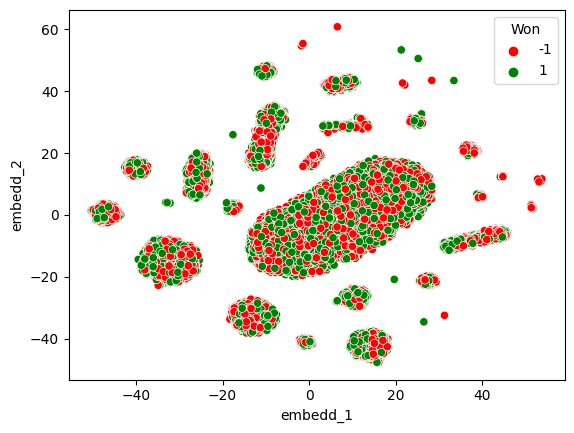

In [28]:
sns.scatterplot(x=tsne_df_tr.embedd_1, y=tsne_df_tr.embedd_2, hue=df_trn.Won, palette=['r', 'g'])

<Axes: xlabel='embedd_1', ylabel='embedd_2'>

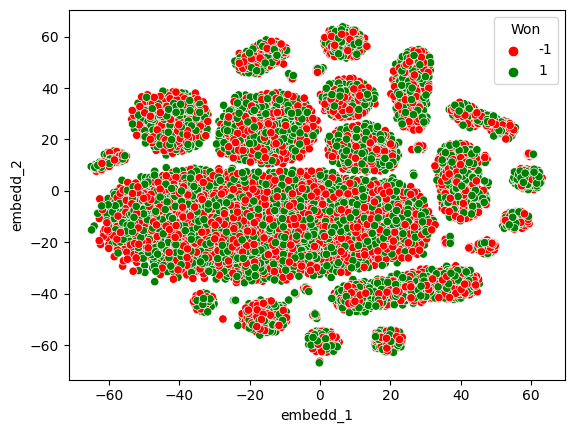

In [29]:
sns.scatterplot(x=tsne_df_ts.embedd_1, y=tsne_df_ts.embedd_2, hue=df_tst.Won, palette=['r', 'g'])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


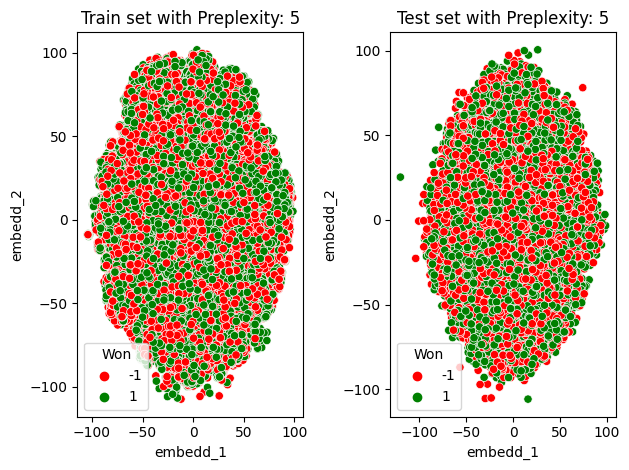

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


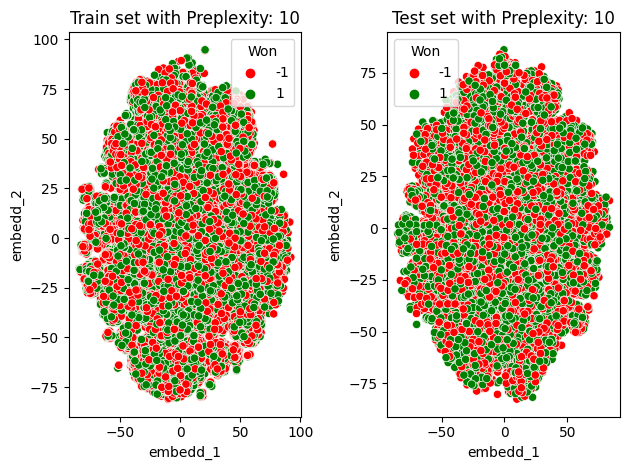

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [16:31:37.942371] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


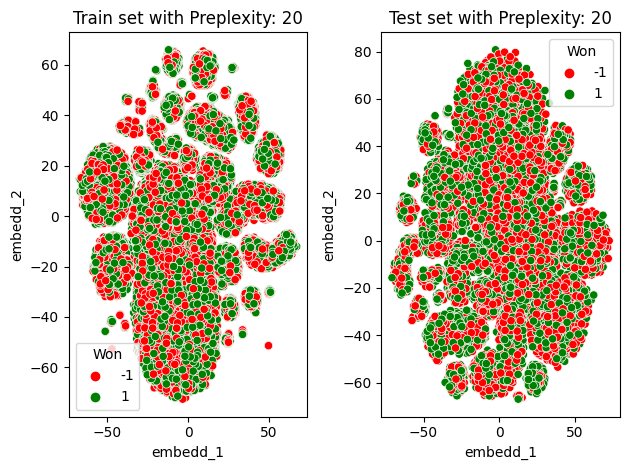

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [16:31:50.079121] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [16:31:54.590541] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


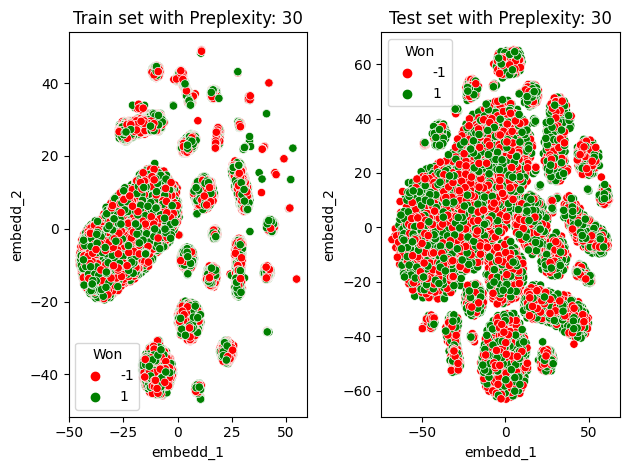

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [16:32:01.004179] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [16:32:05.748827] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


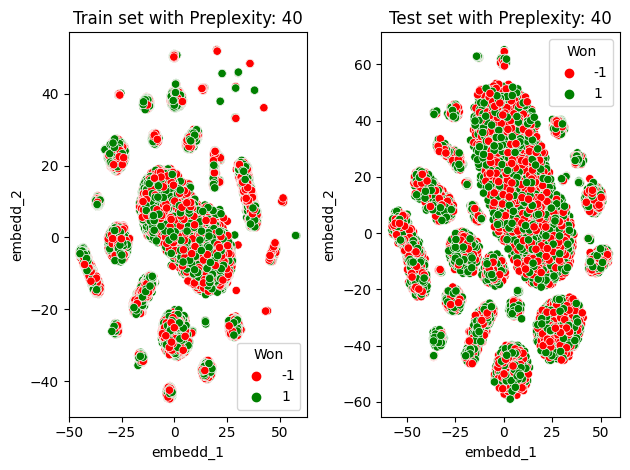

In [8]:
prepel = [5,10,20,30, 40]

for i in prepel:
  tsne = cuml.manifold.TSNE(n_components=2, perplexity=i)

  tsne_no_tr = tsne.fit_transform(df_trn.iloc[:, 1:])
  tsne_no_ts = tsne.fit_transform(df_tst.iloc[:, 1:])

  tsne_no_tr.columns = ['embedd_1','embedd_2']
  tsne_no_ts.columns = ['embedd_1','embedd_2']

  fig, axes = plt.subplots(1, 2)

  ax1 = sns.scatterplot(x=tsne_no_tr.embedd_1, y=tsne_no_tr.embedd_2, hue=df_trn.Won, palette=['r', 'g'], ax=axes[0])
  ax1.set(title=f'Train set with Preplexity: {i}')

  ax2 = sns.scatterplot(x=tsne_no_ts.embedd_1, y=tsne_no_ts.embedd_2, hue=df_tst.Won, palette=['r', 'g'], ax=axes[1])
  ax2.set(title=f'Test set with Preplexity: {i}')

  plt.tight_layout()
  plt.show()

we obviously have some clusters but we can't only use them to predict winners of the games

In [16]:
# free RAM from tsne sets thar we created already

# del tsne_no_ts
# del tsne_no_tr

# gc.collect()

### UMAP  
Lets implement UMAP dimensionality reduction

In [12]:
ump = umap.UMAP()

ump_tr = ump.fit_transform(df_trn.iloc[:, 1:])
ump_ts = ump.fit_transform(df_tst.iloc[:, 1:])

In [18]:
ump_tr_df = pd.DataFrame(ump_tr, columns=['embbeding_1','embbeding_2'])
ump_ts_df = pd.DataFrame(ump_ts, columns=['embbeding_1','embbeding_2'])

<Axes: xlabel='embbeding_1', ylabel='embbeding_2'>

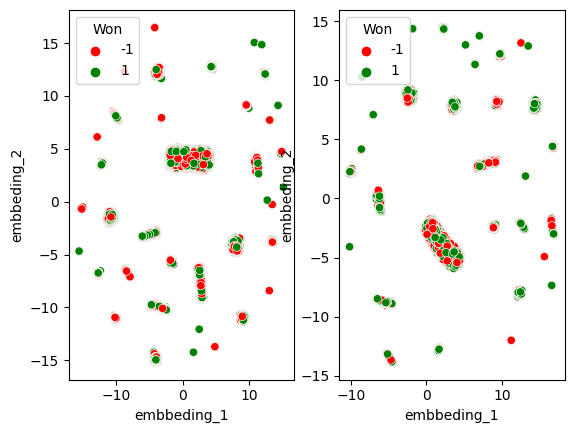

In [20]:
fig, ax = plt.subplots(1,2)

sns.scatterplot(x=ump_tr_df.embbeding_1, y=ump_tr_df.embbeding_2, hue=df_trn.Won, palette=['r', 'g'], ax=ax[0])
sns.scatterplot(x=ump_ts_df.embbeding_1, y=ump_ts_df.embbeding_2, hue=df_tst.Won, palette=['r', 'g'], ax=ax[1])

Sooo it is to hard to solve this classification problem. :/  

AS we can see there are different clusters but they are not pure and we hopefully use unsupervising methods to solve this classification problem.   

---

As we can see UMAP multidimensional scaling make more pure groups, so we use UMAP + (DBSCAN, MeanShift, ...) + Classification Supervised algorirthm.  

**Note:** we should choose an clustering algorithm that is robust to variable shapes of clusters.

### DBSCAN

**Note**: we can not use DBSCAN because it consume so much RAM.

In [14]:
# dbs = DBSCAN(eps=3, min_samples=5)
# dbs.fit(ump_tr)

### MeanShift

**Meanshift on Train set**

In [87]:
bnd = estimate_bandwidth(ump_tr, quantile=0.08, n_samples=1000)

In [89]:
mshift = MeanShift(bandwidth=bnd, bin_seeding=True)
mshift.fit(ump_tr)

MeanShift(bandwidth=3.5514284104296947, bin_seeding=True)

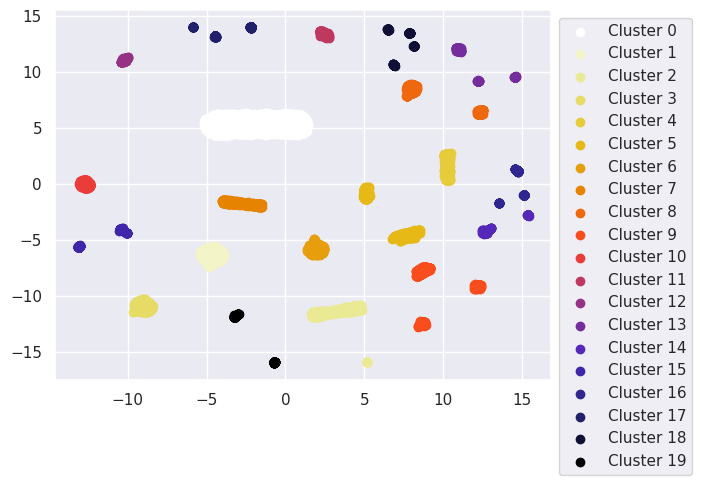

In [90]:
unique_labels = set(mshift.labels_)
n_labels = len(unique_labels)
cmap = plt.cm.get_cmap('CMRmap_r', n_labels)

for l in unique_labels:
    plt.scatter(
        ump_tr[mshift.labels_ == l, 0],
        ump_tr[mshift.labels_ == l, 1],
        c=[cmap(l)],
        label=f'Cluster {l}')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

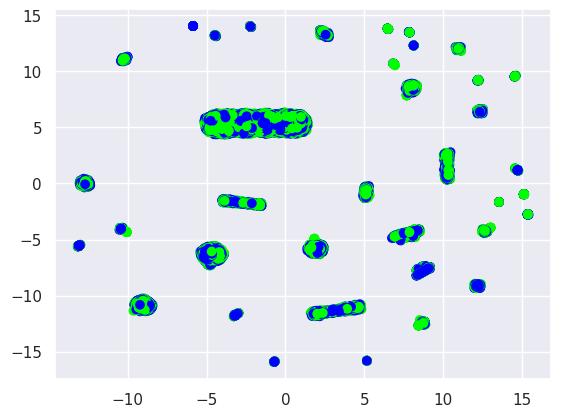

In [91]:
plt.scatter(x=ump_tr_df.embbeding_1, y=ump_tr_df.embbeding_2, c=df_trn.Won, cmap='brg')

**Meanshift on test set**

In [92]:
bnd = estimate_bandwidth(ump_ts, quantile=0.08, n_samples=1000)

In [93]:
mshift_ts = MeanShift(bandwidth=bnd, bin_seeding=True)
mshift_ts.fit(ump_ts)

MeanShift(bandwidth=3.8398256314667605, bin_seeding=True)

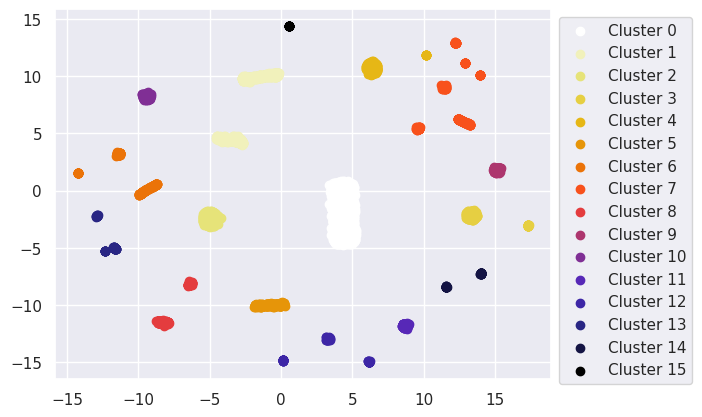

In [94]:
unique_labels = set(mshift_ts.labels_)
n_labels = len(unique_labels)
cmap = plt.cm.get_cmap('CMRmap_r', n_labels)

for l in unique_labels:
    plt.scatter(
        ump_ts[mshift_ts.labels_ == l, 0],
        ump_ts[mshift_ts.labels_ == l, 1],
        c=[cmap(l)],
        label=f'Cluster {l}')
plt.legend(bbox_to_anchor=[1, 1])
plt.show()
plt.rcParams['figure.figsize'] = plt.rcParamsDefault['figure.figsize']

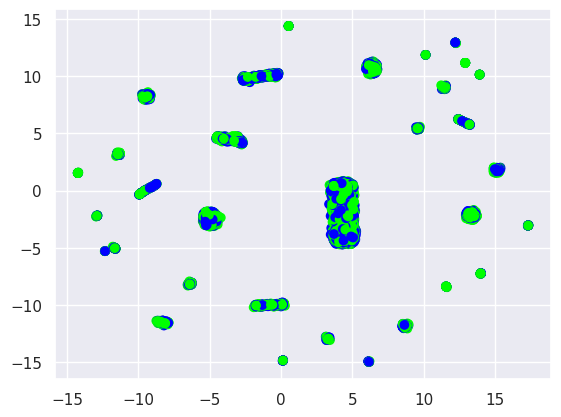

In [95]:
plt.scatter(x=ump_ts_df.embbeding_1, y=ump_ts_df.embbeding_2, c=df_tst.Won, cmap='brg')

I think this bandwidth is good for our analysis.
In next step we try to mix these data and our models

# Modeling

**This part will be update with new clustering techniques**

First we combine train and test set

In [ ]:
df = pd.concat([df_trn, df_tst], axis=0)

In [ ]:
df.isnull().sum().sum()

0

In [ ]:
df.head()

,Won,Region,Server,Game_mode,Game_type,Hero_1,Hero_2,Hero_3,Hero_4,Hero_5,...,Hero_104,Hero_105,Hero_106,Hero_107,Hero_108,Hero_109,Hero_110,Hero_111,Hero_112,Hero_113
0,-1,2,223,2,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,11,152,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4,131,2,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,11,154,2,2,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
4,-1,0,171,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


we remove the region, serve, game_mode, game_type columns

In [ ]:
df = df.drop(columns=['Region','Server','Game_mode', 'Game_type'])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df_trn.iloc[:, 1:].values
y = df_trn.Won

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
pred = knn.predict(X_test)

print(classification_report(y_true=y_test, y_pred=pred))


              precision    recall  f1-score   support

          -1       0.48      0.73      0.58     13160
           1       0.55      0.30      0.39     14635

    accuracy                           0.50     27795
   macro avg       0.52      0.52      0.49     27795
weighted avg       0.52      0.50      0.48     27795



## SVM

In [ ]:
from sklearn.svm import SVC, LinearSVC

In [ ]:
Lsvc = LinearSVC(max_iter=5000)
Lsvc.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=5000)

In [ ]:
pred = Lsvc.predict(X_test)

print(classification_report(y_true=y_test, y_pred=pred))


              precision    recall  f1-score   support

          -1       0.50      0.00      0.00     13160
           1       0.53      1.00      0.69     14635

    accuracy                           0.53     27795
   macro avg       0.51      0.50      0.34     27795
weighted avg       0.51      0.53      0.36     27795



## Logistic-Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logis = LogisticRegression(max_iter=5000)
logis.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

In [ ]:
pred = logis.predict(X_test)

print(classification_report(y_true=y_test, y_pred=pred))


              precision    recall  f1-score   support

          -1       0.58      0.51      0.54     13160
           1       0.60      0.67      0.64     14635

    accuracy                           0.59     27795
   macro avg       0.59      0.59      0.59     27795
weighted avg       0.59      0.59      0.59     27795



## RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
pred = rf.predict(X_test)

print(classification_report(y_true=y_test, y_pred=pred))


              precision    recall  f1-score   support

          -1       0.56      0.50      0.53     13160
           1       0.59      0.65      0.62     14635

    accuracy                           0.58     27795
   macro avg       0.57      0.57      0.57     27795
weighted avg       0.57      0.58      0.57     27795



In [ ]:
pred = rf.predict(X_train)

print(classification_report(y_true=y_train, y_pred=pred))


              precision    recall  f1-score   support

          -1       1.00      1.00      1.00     30708
           1       1.00      1.00      1.00     34147

    accuracy                           1.00     64855
   macro avg       1.00      1.00      1.00     64855
weighted avg       1.00      1.00      1.00     64855



Ooooops we are overfit now :)))))))))))

# Cluster Techniques + Predictive Models

## Kmeans and Models

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

In [ ]:
X = df_trn.iloc[:, 1:]
y = df_trn.Won

In [ ]:
sss = StratifiedShuffleSplit(n_splits=10, random_state=5432)
folds = list(sss.split(X, y))

In [ ]:
def kmeans_cal(k, x_train):
    kms = KMeans(n_clusters=k, init='k-means++')
    kms.fit(X)
    x_train[f'kmeans_{k}'] = kms.labels_
    return x_train

In [ ]:
def get_average10_logis(x, y, folds):
    roc_auc_logistic = []

    for train_idx, test_idx in folds:
        X_train, y_train, X_test, y_test = x.iloc[train_idx, :], y.iloc[train_idx], X.iloc[test_idx, :], y.iloc[test_idx]

        lgs = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
        lgs.fit(X_train, y_train)
        pred = lgs.predict_proba(X_test)[:, 1]
        roc_auc_logistic.append(roc_auc_score(y_true=y_test, y_score=pred))

    mean_roc_auc_logistic = np.mean(roc_auc_logistic)
    return mean_roc_auc_logistic

In [ ]:
k = range(1, 21)
avg_roc_auc_socre_per_cluster = []

for i in k:
    x_trn = kmeans_cal(i, X)
    avg_roc_auc_socre_per_cluster.append(get_average10_logis(x_trn, y, folds))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

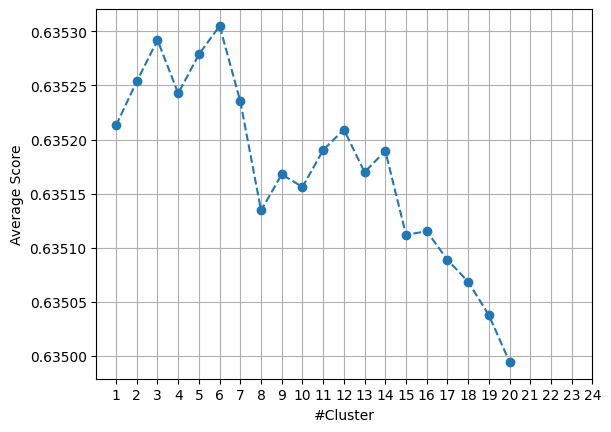

In [ ]:
plt.plot(k, avg_roc_auc_socre_per_cluster, ls='--', marker='o')
plt.xlabel('#Cluster')
plt.ylabel('Average Score')
plt.xticks(range(1, 25))
plt.grid()
plt.show()

We can see after 12 clusters our score is decreasing...  
and best AVG score is for cluster 6   

Lets check another clusterin called DBscan

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
def dbscan_cal(k, x_train):
    dbs = DBSCAN(eps=k, min_samples=5)
    dbs.fit(X)
    x_train[f'dbs_eps_{k}'] = dbs.labels_
    return x_train

In [ ]:
k = range(2, 10)
avg_roc_auc_socre_per_cluster = []

for i in k:
    x_trn = dbscan_cal(i, X)
    avg_roc_auc_socre_per_cluster.append(get_average10_logis(x_trn, y, folds))

In [ ]:
avg_roc_auc_socre_per_cluster

[0.6349902284069568,
 0.634926578237745,
 0.6349866863154613,
 0.6349786067954138,
 0.634971989906815,
 0.634932676429568,
 0.6349447372978403,
 0.6349523775611589]

Kmeans was much more better.  
But both of them are stable in 10 firsts cluster

Lets check our logistic without any clustering

In [ ]:
avg_net = get_average10_logis(X, y, folds)

In [ ]:
avg_net

0.6349523775611589

It is not to far away from score with clustering.  
So we need models tuning techniques and also other models to improve our prediction.  

---

**Note:** remember this we should spend more time with data rather than models tuning